<font size = "5"> **Day 2: [Diffraction and 4D-STEM and Machine Learning](../MLSTEM2025.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />


MLSTEM2025


[Download](https://github.com/gduscher/MLSTEM2025/raw/refs/heads/main/Day2/4_Analyze_CBED_Pattern.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
   https://colab.research.google.com/github/gduscher/MLSTEM2025/blob/main/Day2/4_Analyze_CBED_Pattern.ipynb)


# Dynamic Diffraction and Thermal Diffuse Scattering 
Lecturer: Gerd Duscher

part of the workshop of 

<font size = "5"> **[Machine Learning in Scanning Transmission Electron Microscopy](../MLSTEM2025.ipynb)**</font>


**Day2: Electron Diffraction, 4D-STEM, Differential Phase Contrast, and Variational Auto
Encoder**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**may 2025**

## Overview
We calculate CBED pattern for a scanned area to demonstrate how to derive DPC from CBED pattern of 4D-STEM data set or from images obtained with segmented detectors.

This is important to get training data for further machine learning algorithms and for an understanding of the physical content of the data. 

## Load packages
### Check for Newest Versions



## Load important packages

> In Colab, the next code cell must be run first

### Check Installed Packages

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.2.3':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
    !{sys.executable} -m pip install  --upgrade abtem -q

print('done')

### Load Packages
We will use 
- numpy and matplotlib 
- ase: atomic simulation envronment for crytal definition
- abtem for image simultation

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

import sys
if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()

# import atomic simulation environment
import ase
import ase.spacegroup
import ase.visualize

# import abintio-tem library
import abtem
import  pyTEMlib.kinematic_scattering
import itertools

__notebook__ = 'Thermal_Diffuse_Scattering'
__notebook_version__ = '2025_05_19'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher


## Dynamic Diffraction

Dynamic Diffraction is in the Ewald sphere construction shown as a Bragg spot convoluted with some shape.
This shape refered to as relrod depends on:
- sample shape (Fourier Transform of sample; we are in reciprocal space after all) especially thickness.
- Multiple scattering

Thus the Ewald sphere cuts through this relrod with different excitation errors explaining the pattern in disks and intensities of Bragg spots in SAD.

Even a single atom (if heavy enough) can result in multple scattering

<img src="images/multiple_scattering_single_atom.jpg" alt="multiple scattering_single_atom" width="300" >

For simulation porposes, we will use here the multislice calculation.


### Schrödinger Equation of Bethe Theory

The Bethe theory is based on the (time independent, non relativistic) Schrödinger  equation:

\begin{equation}  
\Big[ \underbrace{ -\frac{h^2}{8\pi^2} \nabla^2 }_{{\rm kinetic\ energy}} +\underbrace{ \mathcal{V}(\vec{r})}_{{\rm pot. energy}} \Big]\, |\psi(\vec{r}) \rangle = \underbrace{\mathcal{E}}_{{\rm total\ energy}} \underbrace{|\psi(\vec{r})\rangle }_{{\rm wave\ function}}
\end{equation} 

What does that mean for the TEM?
>
> We have a acceleration voltage (electric field potential) $E$ of 100kV
>
> We have a charge of the electron $q$ with the value $e$.
>
> We have a total Energy $-\mathcal{E} = E\cdot q$ which is just $E$ in the units of $[eV]$.
>
> We have a crystal with the potential $V(\vec{r})$, which we declare positive inside the crystal and zero outside.
>
> We have a potential Energy $\mathcal{V}(\vec{r}) = q\cdot V(\vec{r})$.


Now, that we declared all our variables we can transform the Schrödinger equation we started with to:

$$
\nabla^2  |\psi(\vec{r})\rangle = -\frac{8\pi m e}{h^2}\,  [E+V]\, |\psi(\vec{r})\rangle 
$$

The left hand part of this equation is the impulse of the electron and the right hand part consists of a total energy part, which is boring and a part which originates from the crystal (interesting!). 


### Bloch Waves in Bethe Theory
Well, if the potential is periodic, then the solution (wave function) must be periodic, too.

First we make a substitution in case our wave function is complicated: we define it as a linear combination of other waves. That is a useful trick, which makes the mathematics easier as we'll see in a bit.
$$
|\psi(\vec{r})\rangle = \sum_j |b_j\rangle \\
|b_j\rangle  =  = |b(\vec{k}^{(j)}, \vec{r})\rangle
$$

The $ |b(\vec{k}^{(j)}, \vec{r})\rangle $ are called Bloch waves and are only defined for specific $\vec{k}$-vectors,
because the  $|b(\vec{k}^{(j)}, \vec{r})\rangle$ are plane waves, each traveling in $k^{(j)}$ direction. For the $|\psi(\vec{r})\rangle$ we did not and could not have made any assumption like that.


Now, we express the fact that these Bloch waves are indeed plane waves mathematically:

\begin{equation}
|b^{(j)}(\vec{r})\rangle  = b(\vec{k}^{(j)}, \vec{r})=\mu(\vec{k}^{(j)}, \vec{r})\cdot e^{2\pi i \vec{k}^{(j)} \vec{r}} = \underbrace{\mu^{(j)}(\vec{r})}_{{\rm Bloch\ function}}   e^{2\pi i \vec{k}^{(j)} \vec{r}}
\end{equation} 

by dividing it in a plane wave part (the exponential function) and a amplitude part (the Bloch function).
Because of the periodicity which we assume for the solution, we expand the Bloch waves in a into a Fourier series, again (the same as in equation of the Fourier expansion for the potential). 

\begin{equation}
b^{(j)}(\vec{r}) = \sum_g C_g^{(j)} e^{2\pi i (\vec{k}^{(j)} + \vec{g}) \vec{r}}
\end{equation}
The sum in this equation goes over all excited (aha!) points in the reciprocal lattice, including the incident direction $g_1 = 0$. (  $\vec{g}$ are defined through the Milller indices as (h/a, k/b, l/c), where the (a,b,c) are the real space lattice vectors).

Theoretically, there are an infinite number of $\vec{g}$ vectors, but only few are allowed and only a few have a small excitation error.  

So in practice there are only a few $\vec{g}$ vectors to consider.

### Solution of Bethe Theory


Now, so far we haven't done anything, but substitute and expand. Let's put all this into the Schrödinger equation : 
\begin{equation}
4\pi \left[ K^2 - (k_0^{(j)} + g)^2 +\sum_{h \neq 0} U_h e^{2\pi i \vec{h}\vec{r} }  \right] \cdot C_g^{(j)} e^{2\pi i (\vec{k}_o^{(j)} +\vec{g})\cdot \vec{r} }= 0
\end{equation}
This can only be zero, if all coefficients with same exponential function simultaneous become zero; this results in a set of equations, after collecting up terms containing the factor 
$e^{2\pi i (\vec{k}_o^{(j)} +\vec{g})\cdot \vec{r} }$:
\begin{equation} 
\left[ K^2 -(\vec{k}_o^{(j)} +\vec{g})^2 \right] C_g^{(j)} + \sum_{h\neq 0} U_h C_{g-h}^{(j)}=0; \qquad \vec{g}=\vec{g}_1, \vec{g}_2, ..., \vec{g}_n 
\end{equation}

I made use of an abbreviation:
\begin{equation}
K=\frac{1}{h}\left[ 2m_0 E (1+\frac{E}{2E_0}) +2m_0 e U_0(1+\frac{E}{E_0}) \right]^{\frac{1}{2}}
\end{equation}
for the wave vector inside the the crystal which are not identical to the magnitude of the wave vectors of the Bloch waves $\vec{k}_g^{(j)}=\vec{k}_o^{(j)} +\vec{g}$.

Please note, that I introduced relativistic corrections (the terms in the round brackets in the equation above), too. It is enough to add this corrections for the energy at this point; it is not necessary to solve the Dirac equation (relativistic  Schrödinger equation).

The set of equations defined in \ref{setEquat} are essential for the  understanding of dynamic diffraction. Let's look at it a little more closely. 

We get for each $j$ one equation; and this means we get for each Bloch wave one equation.

The second term in equation \ref{setEquat} (the term with the sum) mixes the Bloch waves ($C_{g-h}^{(j)}$). Effectively, we state that the inner potential $U_h$ mixes the Bloch waves; this is called dynamical coupling.

> **In summation:**
>
> We separated the problem! 



## Multislice Algorithm

The Mmultisloce algorithm is absed on the Howie Wheeland equation which is equivalent to Bloch equation above.

First we need to define the potential of the slices.

Here we do this with the ``abtem`` package and the structure is made with the ``ase`` package

### Defining the structure


0 Sr [0. 0. 0.]
1 Ti [0.5 0.5 0.5]
2 O [0.5 0.5 0. ]
3 O [0.  0.5 0.5]
4 O [0.5 0.  0.5]


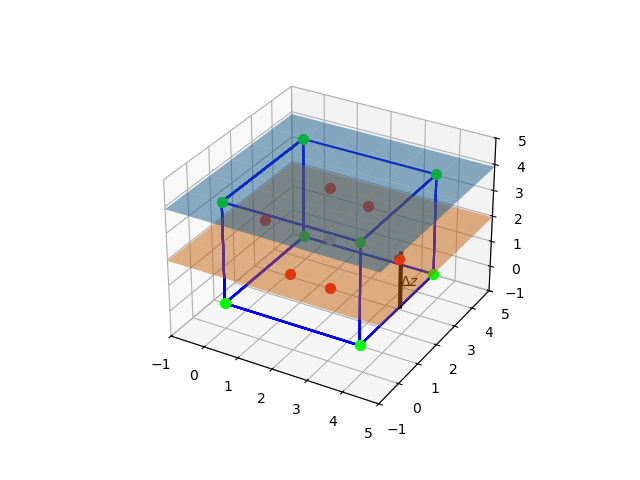

In [2]:
import  pyTEMlib.kinematic_scattering
import itertools
atoms = pyTEMlib.kinematic_scattering.structure_by_name('SrTiO3')
for i in range(len(atoms)):
    print(i, atoms[i].symbol, atoms.get_scaled_positions()[i])

super_cell = pyTEMlib.kinematic_scattering.ball_and_stick(atoms)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Corners and Outline of unit cell
h = (0, 1)
corner_vectors = np.dot(np.array(list(itertools.product(h, h, h))), atoms.cell)
trace = [[0, 1], [1, 3], [3, 2], [2, 0], [0, 4], [4, 5], [5, 7], [6, 7], [6, 4], [1, 5], [2, 6], [3, 7]]
corners = []
for s, e in trace:
    corners.append([*zip(corner_vectors[s], corner_vectors[e])])

    for x, y, z in corners:
        ax.plot3D(x, y, z, color='blue')

for i, atom in enumerate(super_cell.positions):
    ax.scatter(atom[0], atom[1], atom[2],
               color=tuple(pyTEMlib.kinematic_scattering.jmol_colors[super_cell.get_atomic_numbers()[i]]),
               alpha=1.0, s=50)
    
xx, yy = np.meshgrid(range(-1,6), range(-1,6))
z = xx*0+atoms.cell[2][2]
ax.plot_surface(xx, yy, z, alpha=0.5)
ax.plot_surface(xx, yy, z-atoms.cell[2][2]/2, alpha=0.5)
ax.text(5, 0., atoms.cell[2][2]*.7, "$\Delta z$", color='black')
ax.plot([5, 5], [0,0],zs=[atoms.cell[2][2]/2, atoms.cell[2][2]], color='black', linewidth=3)
ax.set_xlim(-1, 5)
ax.set_ylim(-1, 5)
ax.set_zlim(-1, 5);

Here we make a SrTiO$_3$ crystal again

In [3]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = ase.spacegroup.crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(4, 4, 16))
srtio3.center()
ase.visualize.view(srtio3, viewer='x3d')  

However, as before we need more atoms laterally and more layers.
> Please note:
>
> all length in abTEM are in Angstrom

Simulation cell: Cell([19.525, 19.525, 156.2])


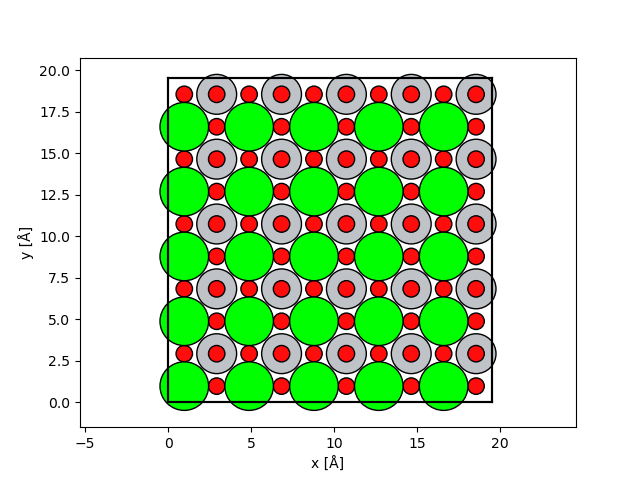

In [4]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = ase.spacegroup.crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(5, 5, 40))

srtio3.center()
print(f"Simulation cell: {srtio3.cell}")
abtem.show_atoms(srtio3);

### Defining the potential

In [5]:
potential = abtem.Potential(srtio3, 
                      gpts=512, 
                      slice_thickness=3.904/2, 
                      parametrization='kirkland', 
                      projection='infinite')

potential.sampling
wave = abtem.PlaneWave(energy=200e3, sampling=.05)

### Multislice

[########################################] | 100% Completed | 11.04 s


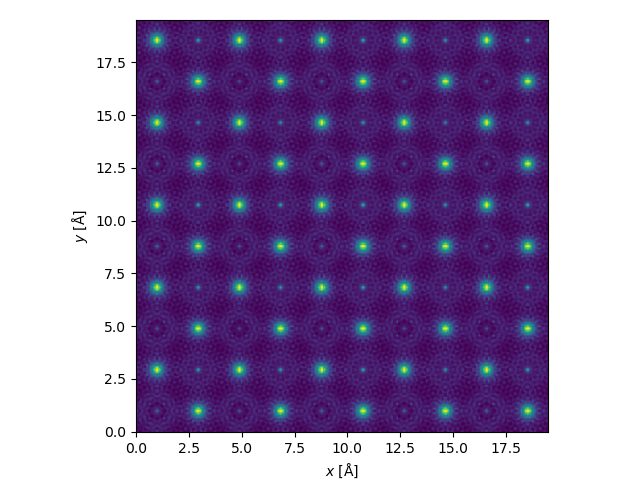

In [6]:
exit_wave = wave.multislice(potential)
exit_wave.show()

### Plot Diffraction Pattern

[########################################] | 100% Completed | 7.22 ss


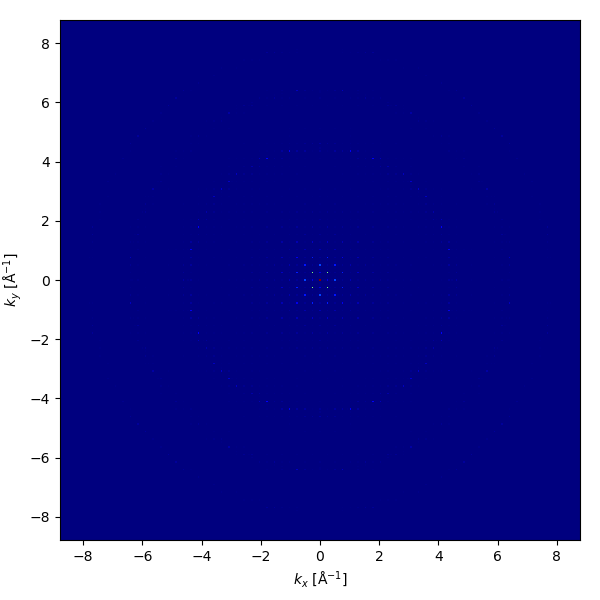

In [7]:
diffraction_pattern = exit_wave.diffraction_patterns()
diffraction_pattern.block_direct()

vis = diffraction_pattern.show(power=.4, figsize=(6,6), cmap='jet')

## Thermal Diffuse Scattering
The atoms in any real material are not exactly located at their symmetrical lattice points due to thermal and zero-point vibrations. The ``frozen phonon`` approximation is a simple to simulate the effects of thermal vibrations. 

The scattering that is associated with thermal lattice vibrations is called ``thermal diffuse scattering (TDS)``.
In the following, we investigate the effect of thermal diffuse scattering in the frozen phonon approximation on diffraction pattern.

### Structure and Debey Waller Factor

Each atom is allowed to deviate from its symmetrical lattice position with a Gaussian distribution and
an ``root mean square`` **rms** deviation of $x_{RMS}$  in each of three directions. This is equivalent to the Einstein model of the density of states for phonons.

This standard deviation of this Gaussiam distribution $x_{RMS}$ for most materials is about 0.1Å:

The relation of the Debey-Waller Factors in the literature to the deviation of position $x_{RMS} = \sqrt{B/(8\pi^2)}$.

The ``FrozenPhonon class`` of the abtem package generates offsets from such a Gaussian distribution  using a random number generator with a given seed. 

The standard deviation of the Gaussian distribution is provided for each element as a dictionary.


In [8]:
# ------ Input ------ #
number_of_frozen_phonon_runs = 12
# --------------------#
frozen_phonons = abtem.FrozenPhonons(srtio3, number_of_frozen_phonon_runs, {'Sr': 0.1, 'Ti': 0.1, 'O': 0.1}, seed=100)

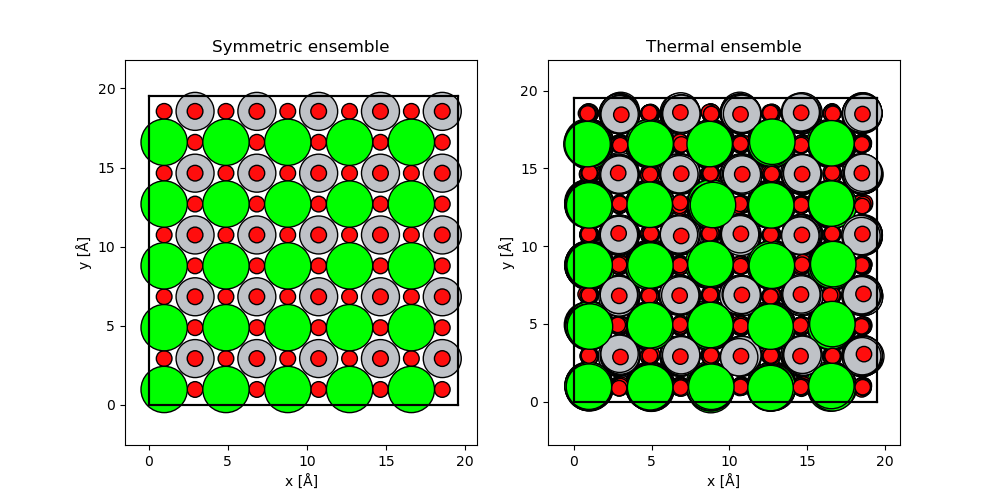

In [9]:
atoms_conf = next(iter(frozen_phonons))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

abtem.show_atoms(srtio3, ax=ax1)

abtem.show_atoms(atoms_conf, ax=ax2);
ax1.set_title('Symmetric ensemble')
ax2.set_title('Thermal ensemble');

### Building a potential 

In [10]:
tds_potential = abtem.Potential(frozen_phonons, gpts=432, slice_thickness=3.905/2)
print(f"Real space sampling: {tds_potential.sampling} Angstrom ")

Real space sampling: (0.045196759259259256, 0.045196759259259256) Angstrom 


In [11]:
tds_exit_waves = wave.multislice(tds_potential)
tds_exit_waves.compute()

[########################################] | 100% Completed | 20.52 s


### Averaging thermal diffuse scattering calculations.

The need for averaging of the thermal diffuse scattering becomes clear in  the following figure.

Each atom position has to have many deviations to be averaged out in the center. This is waht makes this process so long and what makes the process obvious for (embarrassingly) parallel methods.

Text(0.5, 1.0, 'Thermal ensemble')

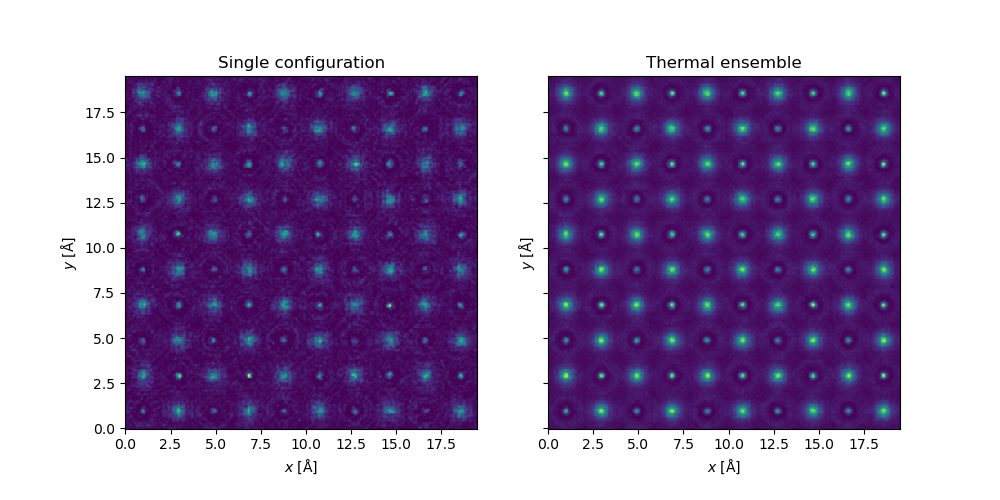

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

tds_exit_waves[0].show(ax=ax1)
ax1.set_title('Single configuration')
tds_exit_waves.intensity().mean(0).show(ax=ax2)
ax2.set_title('Thermal ensemble')

### Plot Diffraction Pattern

The Kikuchi notebook explained that the source for the Kikuchi pattern formation is inside the sample. Here we have the origin of this source. The thermal diffuse scattering makes the electrons scatter into high angles and that is needed to capture these features in a simulation. 

> So when you see Kikuchi bands you actually see the effect of phonons.


[########################################] | 100% Completed | 7.73 ss


Text(0.5, 1.0, 'Averaged thermal ensemble')

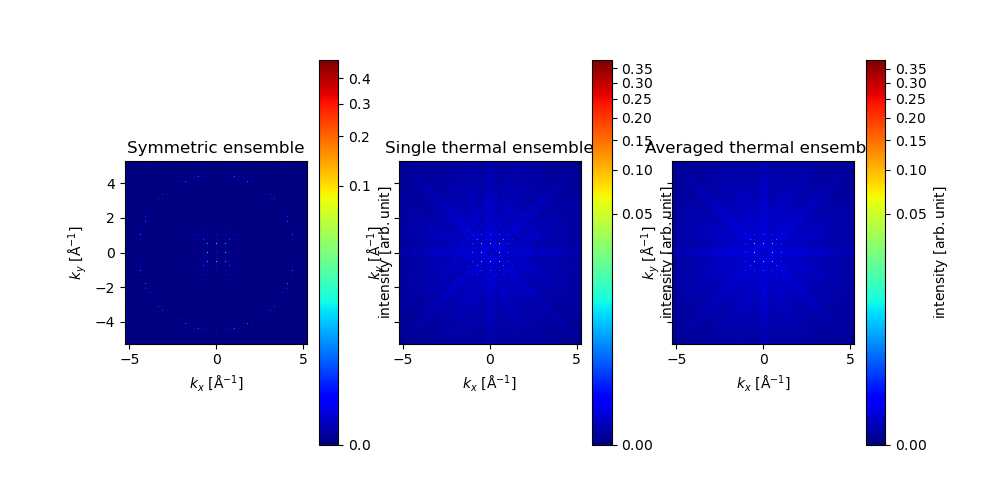

In [13]:
tds_diffraction_pattern = tds_exit_waves.diffraction_patterns('valid')
tds_diffraction_pattern.compute()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5), sharex=True, sharey=True)

diffraction_pattern.show(power=.25, cmap='jet', ax=ax1, cbar=True)
ax1.set_title('Symmetric ensemble')
tds_diffraction_pattern[0].show(power=.25, cmap='jet', ax=ax2, cbar=True)
ax2.set_title('Single thermal ensemble')

tds_diffraction_pattern.mean(0).show(ax=ax3, cmap='jet', power=.25, cbar=True)
ax3.set_title('Averaged thermal ensemble')

[########################################] | 100% Completed | 7.53 ss


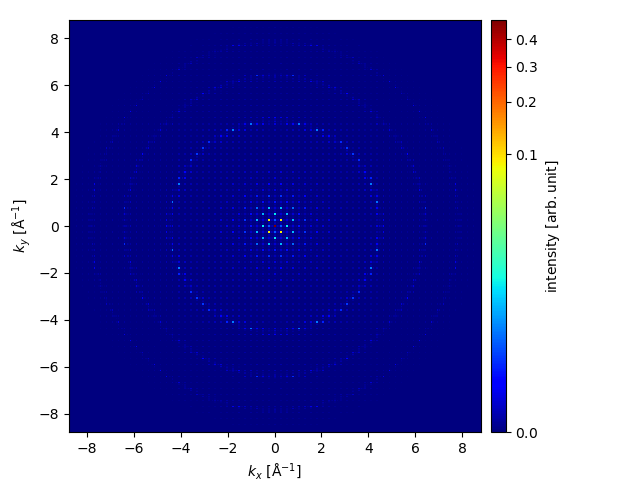

In [14]:
diffraction_pattern.show(power=.25, cmap='jet',cbar=True)

## CBED and Thermal Diffuse Scattering

### Make the probe 
The probe has to be on the same grid (matrix, pixels) as the potential, which is ensured with the ``grid.match`` function.

[########################################] | 100% Completed | 205.95 ms


(512, 512)

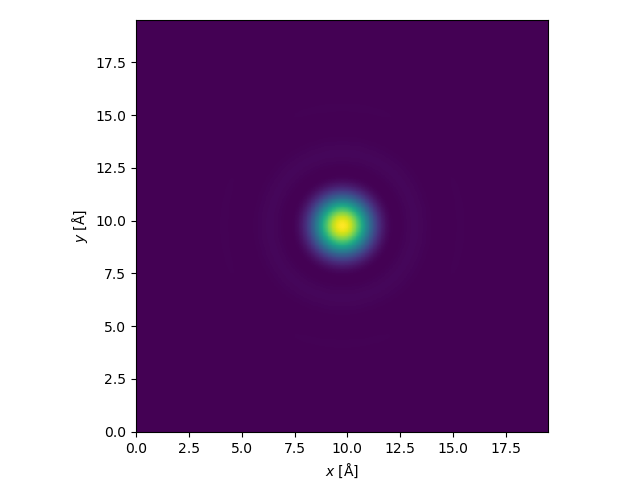

In [15]:
# ---- Input ----- #
convergence_angle = 7  # in mrad of half angle
acceleration_voltage = 150e3 # in V
defocus = 0  # in nm
# -----------------#

probe = abtem.Probe(energy=acceleration_voltage, semiangle_cutoff=convergence_angle, 
                     defocus=defocus, Cs=3e5)
probe.grid.match(potential)

probe.show(),
probe.shape

### Symmetric ensemble

[########################################] | 100% Completed | 6.81 sms


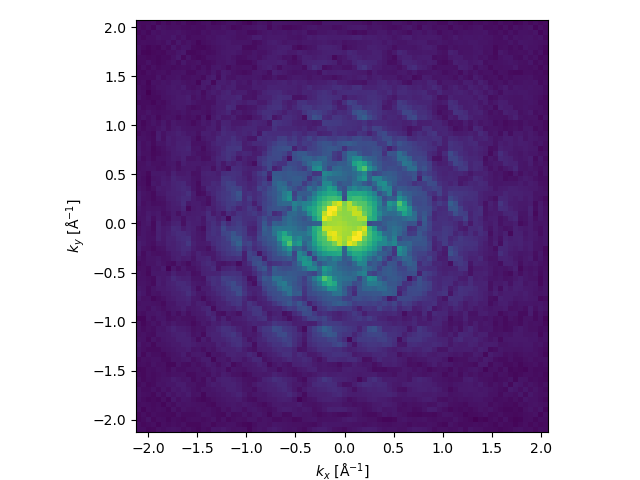

In [16]:
detector = abtem.PixelatedDetector(max_angle='full')
detector = abtem.PixelatedDetector(max_angle=60)
cbed = probe.build().multislice(potential, detectors=[detector])
cbed.show(power=0.25)

### TDS
For the thermal diffuse scattering like above for the symetric ensemble we reuse the potential from the plane wave calculation and just change the probe. The probe was definded in the symmetric enseble calculation above.

The calculation takes about 1 min on my laptop.

[########################################] | 100% Completed | 8.43 sms


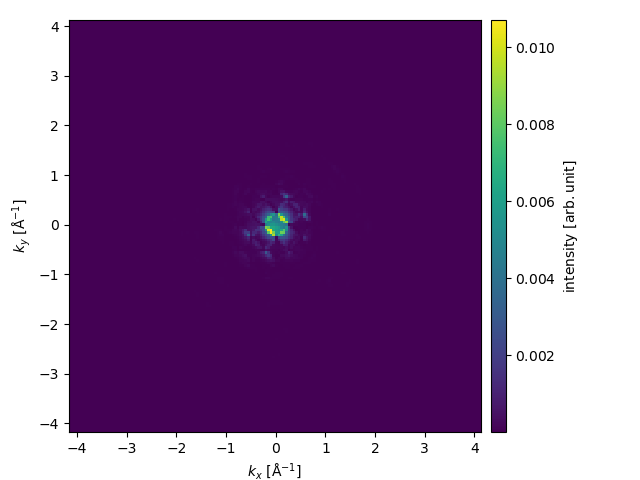

In [17]:
# ------ Input ------ #
number_of_frozen_phonon_runs = 1
# --------------------#
frozen_phonons = abtem.FrozenPhonons(srtio3, number_of_frozen_phonon_runs, {'Sr': 0.1, 'Ti': 0.1, 'O': 0.1}, seed=10)
tds_potential = abtem.Potential(frozen_phonons, gpts=512, slice_thickness=3.905/2)


detector = abtem.PixelatedDetector(max_angle=120)
tds_cbed = probe.build().multislice(tds_potential, detectors=[detector])
tds_cbed.compute()
tds_cbed.show(cbar=True)

### Comparison

[########################################] | 100% Completed | 6.71 sms


Text(0.5, 1.0, 'Thermal ensemble')

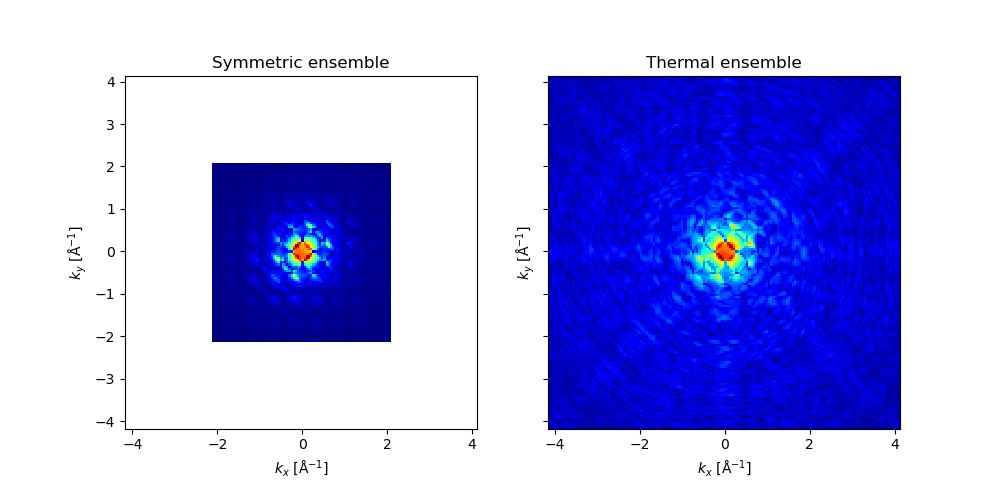

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

cbed.show(power=.4, cmap='jet', ax=ax1)
ax1.set_title('Symmetric ensemble')
tds_cbed.show(power=.3, cmap='jet', ax=ax2)
ax2.set_title('Thermal ensemble')

Redo this calculation with non overlapping disks in the convergence angle (let's say 7 mrad at 80keV)
You can jump to [Make the probe](###Make_the_probe)

## Summary

For a quantitative image simulation we need to do dynamic scattering theory. 

The dynamic scattering theory is done within the multislice algorithm that treats each slice like a weak phase object.


>
> Thermal defuse scattering needs to be included into the multislice calculations for a good simulation
>

The thermal diffuse scattering can be approximated by the frozen phonon approximation but it is computationally intensive.

All kinematic and dynamic features of a diffraction pattern can be simulated well enough to serve as input for machine learning.



In [20]:
# ------------ Input ----------
thickness = 22. #  in nm
number_of_layers = 4  # per unit cell
#------------------------------

atoms = ase.build.bulk('Si', 'diamond', cubic=True)
lattice_parameter = atoms.cell[2,2]
layers = int(thickness / lattice_parameter *10)
atoms *= (32, 32, layers)

atoms.center()

In [97]:
sigma = 0.1256
frozen_phonons = abtem.FrozenPhonons(atoms, 12, {'Si': sigma}, seed=13, directions='xyz')



AttributeError: 'Potential' object has no attribute 'calculate'

In [86]:
# -------- Input --------
convergence_angle = 5  # in mrad
device = 'cpu'
# -----------------------

probe = abtem.Probe(energy=200e3, semiangle_cutoff=convergence_angle,  device=device)
probe.grid.match(einstein_potential)

In [87]:
detector = abtem.PixelatedDetector(max_angle='full')

In [95]:
measurement = probe.build().multislice(einstein_potential,  detectors=detector).compute()

[#################                       ] | 42% Completed | 1.54 s ms

C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\abtem\potentials\iam.py:1181: RuntimeWarning: overflow encountered in multiply
  waves._array *= self.array[0]
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\abtem\potentials\iam.py:1181: RuntimeWarning: invalid value encountered in multiply
  waves._array *= self.array[0]
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\abtem\core\fft.py:93: RuntimeWarning: invalid value encountered in multiply
  array *= kernel


[########################################] | 100% Completed | 94.83 s


In [96]:
measurement.array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)